In [58]:
import gzip
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error 

start_year = 1900
end_year = 2021

words = []
data_year = []

with gzip.open('C:/Users/bincl/BA-Thesis/Dataset/1gram/1_20000_nopos.gz', 'rt', encoding='utf-8') as input:
    for line in input:
        values = line.strip().split("\t")
        words.append(values[0])
        data = [entry.split(",") for entry in values[1:]]
        year = {int(entry[0]): entry[1] for entry in data if start_year <= int(entry[0]) <= end_year}
        data_year.append(year)

years = list(range(start_year, end_year + 1))
df1gram = pd.DataFrame(index=words, columns=years)

for i, word_data in enumerate(data_year):
    word = words[i]
    for year, value in word_data.items():
        df1gram.at[word, year] = value

df1gram.fillna(0, inplace=True)
print(df1gram)

                1900   1901   1902   1903   1904   1905   1906   1907   1908  \
Empfehlungen    2772   2418   2466   2939   3010   2945   3344   3636   3354   
Fachbereich       18      5      0      5      0      1      1      5      7   
Besprechungen   9201  10329  11539  11474  12928  12706  14154  13283  14325   
Berechtigung   36992  41263  43328  44095  47043  50863  54312  54353  55122   
Beiträgen      11657  12092  13215  12741  14330  14318  17206  15555  16436   
...              ...    ...    ...    ...    ...    ...    ...    ...    ...   
geistig        16840  19841  20536  21125  25894  25610  28848  27045  29084   
einsetzte       2917   3296   3551   4132   4378   4915   5354   5703   6062   
fasziniert        36     43     48     71    134    203    215    262    243   
fährt          19865  19755  21965  22859  23231  24609  25505  26038  28560   
jeweiligen     17833  20031  20835  21655  23959  24925  28730  28865  29898   

                1909  ...    2012    20

In [59]:

words = []
data_year = []

with gzip.open('C:/Users/bincl/BA-Thesis/Dataset/2gram/2_20000_nopos_aa.gz','rt', encoding='utf-8') as input:
    for line in input:
        values = line.strip().split("\t")
        words.append(values[0])
        data = [entry.split(",") for entry in values[1:]]
        year = {int(entry[0]): entry[1] for entry in data if start_year <= int(entry[0]) <= end_year}
        data_year.append(year)

years = list(range(start_year, end_year + 1))
df2gram = pd.DataFrame(index=words, columns=years)

for i, word_data in enumerate(data_year):
    word = words[i]
    for year, value in word_data.items():
        df2gram.at[word, year] = value

df2gram.fillna(0, inplace=True)
print(df2gram)


                            1900 1901 1902 1903 1904 1905 1906 1907 1908 1909  \
derartige Beachtung            4    2    9    6    2    8    6   10    6    0   
des Cotta                     19    6   12   17   12   15   24    9    8   22   
derartige Herausforderungen    0    0    9    1    0    0    6    5    0    0   
derartigen Feuer               2    0    0    3    5    1    0    4    8    2   
derselben einzuschränken       8    6   19   10    7   28   14    7   12   13   
...                          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
Transformation vorwiegend      0    0    0    0    0    0    0    0    0    0   
Titel ihrer                  358  356  143   85   95  100   99   90  112   90   
Trotz Einwilligung             0    0    0    0    0    0    0    0    0    0   
Titel beurteilt                0    0    0    0    0    1    1    1    5    0   
Tode Julius                   34   27   18   15   33   32   29   23   25   10   

                           

Remove first and last token of Time Series Gi and get the n-1 gram

In [84]:
def getLowerLevelString(string):
   first, *middle, last = string.split()
   first = first + ''.join(middle)
   last = ''.join(middle) + last
   return first, last

Calculate the RMSE error between two functions

Linear Regression Testcase:

In [85]:

def MLR(token):
    first,last = getLowerLevelString(token)
    X = pd.concat([df1gram.loc[first],df1gram.loc[last]],axis=1)
    y = df2gram.loc[token]
    reg = LinearRegression()
    reg.fit(X, y) 
    return reg.coef_,reg.intercept_,X

Prints coefficients

1900    358
1901    356
1902    143
1903     85
1904     95
       ... 
2017    304
2018    259
2019    216
2020      0
2021      0
Name: Titel ihrer, Length: 122, dtype: object


<Axes: >

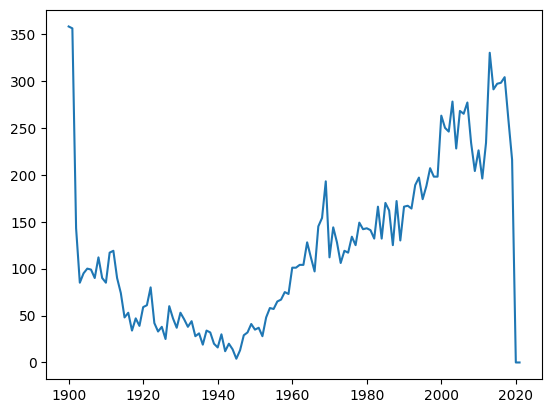

In [86]:
plt.ticklabel_format(style = 'plain')
real = df2gram.loc['Titel ihrer']
print(real)
real= pd.to_numeric(real)
real.plot()

In [87]:
coef,interc,dfAprox = MLR('Titel ihrer')
c1,c2 = coef
print(interc)
print(dfAprox.iloc[:,1])

-3.2125862479288543
1900     948603
1901    1010780
1902    1063859
1903    1090601
1904    1190762
         ...   
2017    4513276
2018    3826698
2019    3366090
2020          0
2021          0
Name: ihrer, Length: 122, dtype: object


Plot new aproximation (c1 und c2 vertauschen bringt bessere results wieso? random?)

In [88]:
#print(dfAprox)
#dfAprox.fillna(0)
def buildApproximation(c1,c2,df):
    df = df.astype('float')
    df['scaledFirst'] = df.iloc[:,1].apply(lambda x: x * c1) 
    df['scaledLast'] = df.iloc[:,2].apply(lambda x: x * c2) 
    #dfAprox['approximation'] = (dfAprox['scaledFirst'] + dfAprox['scaledLast']
    df['approximation'] = (df['scaledFirst'] + df['scaledLast']) 
    return df
#print(dfAprox)
#dfAprox['approximation'].plot()


RMSE between Approximation and original

In [89]:
dfAprox = buildApproximation(c1,c2,dfAprox)
rmse = mean_squared_error(real, dfAprox['approximation'], squared = False)
print(rmse)

1161.77510172795


Now for all error bound 2grams 

In [90]:
def compressWithError2gram(firstN,error):
    df_N_2gram = df2gram.head(firstN)
    
    result = []
    for ngram in df_N_2gram.index.values:
        coef,interc,dfAprox = MLR(ngram)
        c1,c2 = coef
        df = buildApproximation(c1,c2,dfAprox)
        
        dfOriginal = df2gram.loc[ngram]
        dfOriginal= pd.to_numeric(dfOriginal)
        rmse = mean_squared_error(dfOriginal, df['approximation'], squared = False)
        if rmse <= error:
            result.append([ngram,rmse,dfOriginal,df['approximation']]) 
    return result

In [94]:
result = compressWithError2gram(1000,0.5)
print(len(result))

47


<Axes: >

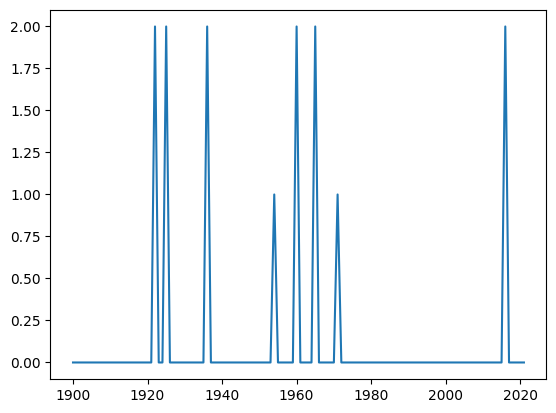

In [97]:
result[3][2].plot()

<Axes: >

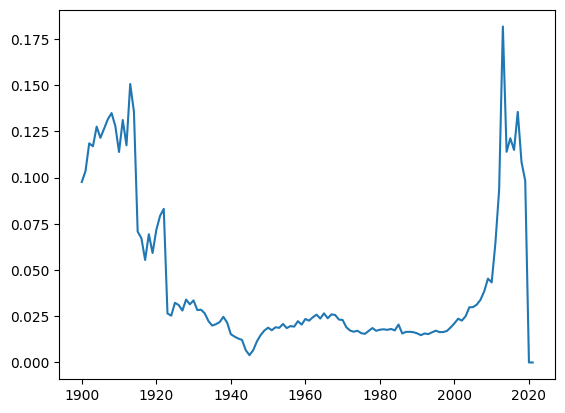

In [98]:
result[3][3].plot()